In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [46]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
min_perc = 80

## How many transcript isoforms do we detect (filtered) from each GM12878 sample?

In [47]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 191325


In [48]:
# limit to gm libraries
df = df[[c for c in df.columns if 'gm12878' in c]]
df = df.transpose()

# get # isoforms
df['n_things'] = (df>min_tpm).sum(axis=1)
df.reset_index(inplace=True)
df.rename({'index':'library'}, axis=1, inplace=True)

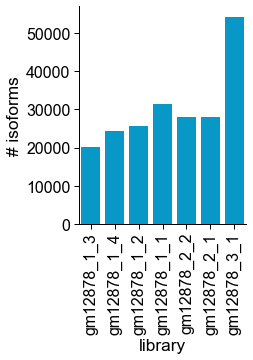

In [49]:
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
c_dict, order = get_biosample_colors()
c = c_dict['gm12878']

ax = sns.barplot(df, y='n_things', x='library', color=c, saturation=1)
ax.tick_params(axis="x", rotation=90)
ylabel = '# isoforms'
ax.set(ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

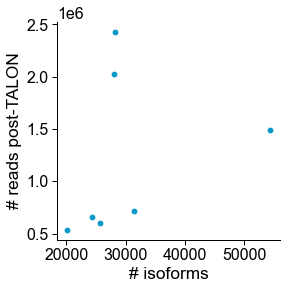

In [50]:
# compare to number of reads 
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta[['dataset', 'reads_post_talon']]
df = df.merge(meta, how='left', left_on='library', right_on='dataset')
df.head()


sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, y='reads_post_talon', x='n_things', s=40, color=c)
xlabel = '# isoforms'
ylabel = '# reads post-TALON'
ax.set(ylabel=ylabel, xlabel=xlabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## What about ICs?

In [51]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='ic',
               min_tpm=min_tpm,
               gene_subset=gene_subset)

Calculating ic TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 131409
Applying gene type and novelty subset
Number of ics reported: 113956


In [52]:
# limit to gm libraries
df = df[[c for c in df.columns if 'gm12878' in c]]
df = df.transpose()

# get # isoforms
df['n_things'] = (df>min_tpm).sum(axis=1)
df.reset_index(inplace=True)
df.rename({'index':'library'}, axis=1, inplace=True)

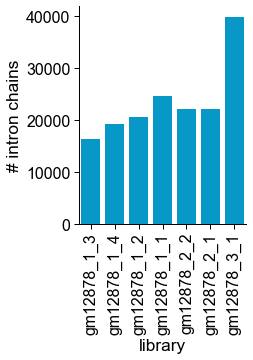

In [53]:
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
c_dict, order = get_biosample_colors()
c = c_dict['gm12878']

ax = sns.barplot(df, y='n_things', x='library', color=c, saturation=1)
ax.tick_params(axis="x", rotation=90)
ylabel = '# intron chains'
ax.set(ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

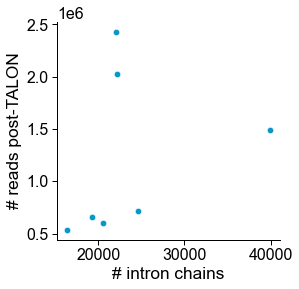

In [54]:
# compare to number of reads 
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta[['dataset', 'reads_post_talon']]
df = df.merge(meta, how='left', left_on='library', right_on='dataset')
df.head()


sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, y='reads_post_talon', x='n_things', s=40, color=c)
xlabel = '# intron chains'
ylabel = '# reads post-TALON'
ax.set(ylabel=ylabel, xlabel=xlabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)